# sMRI Acquisition and Modalities

---

Objectives:
* Visualize the understand differences in T1, T2, PD/FLAIR weighted images.

## Image Acquisition

* The acquisition starts with application of strong magnetic field $B_0$ (e.g. 1.5 or 3.0 Tesla > 10000x earth’s magnetic field) which forces the hydrogen nuclei of the abundant water molecules in soft tissues in the body to align with the field.
* Then the scanner applies a radio-frequency (RF) (i.e. excitation) pulse which tilts these nuclei from their alignment along B0. The nuclei then precess back to the alignment. The precessing nuclei emit a signal, which is registered by the receiver coils in the scanner.
* This signal has two components:
  * Longitudinal (z-axis along the scanner’s magnetic field) and
  * Transverse (xy-plane orthogonal to the scanner’s magnetic field).
* Initially the longitudinal signal is weak as most nuclei are tilted away from the z-axis. However this signal grows as nuclei realign. The time constant that dictates the speed of re-alignment is denoted by T1.
* Initially the transverse signal is strong as most nuclei are in phase coherence. The signal decays as the nuclei dephase as they realign. This decay is denoted by the T2 time constant.
* The tissue specific differences in T1 and T2 relaxation times is what enables us to see anatomy from image contrast. The final image contrast depends on when you listen to the signal (design parameter: echo time (TE)) and how fast you repeat the tilt-relax process i.e. RF pulse frequency (design parameter: repetition time (TR)).

In [1]:
local_data_dir = 'local_data/1_sMRI_modalities'

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import nilearn
from nilearn import datasets
from nilearn import plotting
import pandas as pd
import matplotlib as mpl
import seaborn as sns

C:\Language\Miniconda3\lib\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## T1 and T2 relaxation and image contrast

![singal from two different tissues](imgs/t1_t2_relaxation.gif)

* Here we see signal from two different tissues as the nuclei are tilted and realigned.
  * The figure on the left shows a single nucleus (i.e. tiny magnet) being tilted away and then precessing back to the the initial alighment along $B_0$.
  * The figure on the right shows the corresponding registered T1 and T2 signal profiles for two different “tissues”.
  * The difference in their signal intensities results in the _image contrast_.

### T1

The longitude (or spin-lattice) relaxation time is the decay constant for the recovery of the z component of the nuclear spin magnetization, $M_z$, towards its thermal equilibrium value, $M_{z_eq}$.

### T2

The transverse (or spin-spin) relaxation time $T_2$ is the decay constant for the component of M perpendicular to $B_0$, designated $M_{xy}$.

### T1 and T2 relaxation times for various tissues

|  | T1 (ms) | T2 (ms) |
|:---:|:---:|:---:|
| Bones | 500 | 50 |
| CSF | 4000 | 500 |
| Gray Matter | 1300 | 110 |
| White Matter | 800 | 80 |

In the T1w image, brightness is ranked in White matter > Grey Matter > CSF (Cerebrospinal fluid).

In [3]:
def get_Mz(T1, t, M_eq=1):
    Mz = M_eq * (1 - np.exp(-t/T1))
    return Mz

def get_Mxy(T2, t, Mxy_0=1):
    Mxy = Mxy_0 * np.exp(-t/T2)
    return Mxy

# params
T1_dict = {'GM': 1200, 'WM': 800, 'CSF': 4000, 'Bone': 500}
T2_dict = {'GM': 110, 'WM': 80, 'CSF': 750, 'Bone':50}

T1_duration = np.arange(0, 4500, 500)
T2_duration = np.arange(0, 500, 100)

relax_df = pd.DataFrame()

# T1 signal
for tissue, T1 in T1_dict.items():
    _df = pd.DataFrame()
    Mz = get_Mz(T1, T1_duration)
    _df['time'] = T1_duration
    _df['signal'] = Mz
    _df['relaxation'] = 'T1'
    _df['tissue'] = tissue

    relax_df = relax_df.append(_df)

# T2 signal
for tissue, T2 in T2_dict.items():
    _df = pd.DataFrame()
    Mxy = get_Mxy(T2, T2_duration)
    _df['time'] = T2_duration
    _df['signal'] = Mxy
    _df['relaxation'] = 'T2'
    _df['tissue'] = tissue

    relax_df = relax_df.append(_df)

relax_df.head()

,time,signal,relaxation,tissue
0,0,0.000000,T1,GM
1,500,0.340759,T1,GM
2,1000,0.565402,T1,GM
3,1500,0.713495,T1,GM
4,2000,0.811124,T1,GM


## Brain tissue comparison

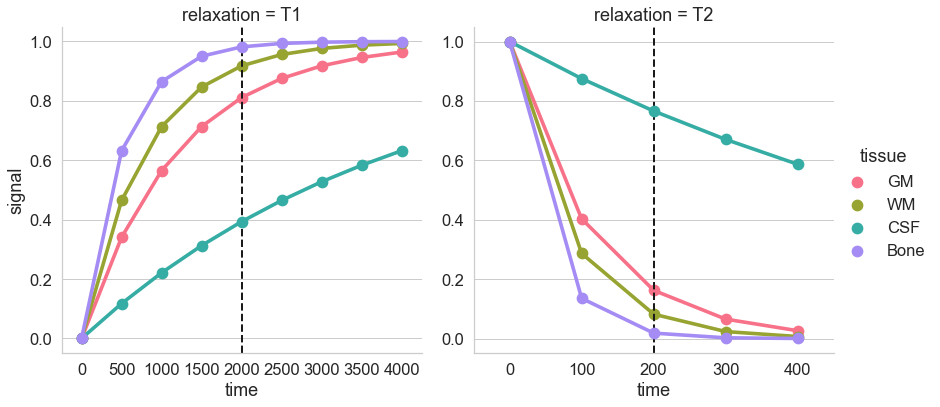

In [15]:
plot_df = relax_df.copy()
T1_TE = 4
T2_TE = 2

sns.set(font_scale=1.5)
mpl.rcParams['lines.linewidth'] = 2
# Return a specified number of evenly spaced hues in the “HUSL” system:
palette = sns.color_palette('husl', 4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='signal',
                    x='time',
                    hue='tissue', # category
                    col='relaxation', # For different kind of weight
                    kind='point', # The kind of plot to draw,
                    data=plot_df,
                    palette=palette,
                    height=6,
                    aspect=1,
                    sharey=False,
                    sharex=False)
    ax1, ax2 = g.axes[0]
    # Add a vertical line across the Axes
    ax1.axvline(x=T1_TE, label='Echo Time', c='k', linestyle='--')
    ax2.axvline(x=T2_TE, label='Echo Time', c='k', linestyle='--')

The dotted-black line represents the epoch when you "listen" to the signal (i.e., echo time or TE).

## T1w, T2w, and PD acquisition

|  | TE short | TE long(~T2 of tissue of interest) |
|:---:|:---:|:---:|
| TR short (~T1 of tissue of interest) | T1w | - |
| TR long | Proton Density (PD) | T2w |

More recently, the FLAIR (Fluid Attenuated Inversion Recovery) sequence has replaced the PD image. FLAIR images are T2-weighted with the CSF signal suppressed.

Repetition time (TR) and echo time (TE) are the two pulse sequence parameters that dictate the T1w and T2w image contrasts. TR > TE.

## T1w, T2w image contrasts


T1w            |  T2w
:-------------------------:|:-------------------------:
![T1w](imgs/T1.gif)  |  ![T2w](imgs/T2.gif)

![T1_T2_FLAIR](imgs/t1_t2_t2flair.png)

## Applications per modality

| Modality | Contrast Characteristics | Use cases |
|:---:|:---:|:---:|
| T1w | CSF is dark | Quantifying anatomy  e.g., measure structural volumes |
| T2w | CSF is light, but white matter is darker than with T1 | Identify pathologies related to lesions and tumors |
| PD | CSF is bright. Gray matter is brighter than white matter | Identify demyelination |
| FLAIR | Similar to T2 with the CSF signal suppressed | Identify demyelination |

## Image Acquisition process and Parameters

![Pulse_seq](imgs/Pulse_seq.png)

## What do we want?

* High image contrast
* High spatial resolution
* Low scan time

## What we can control?

### Magnetic strengths 1.5T vs 3T vs 7T

Higher magnetic strength -> better spatial resolution, better SNR ($S \propto B_0^2)$; but more susceptible to certain artifacts.

### MR sequences (i.e. timings of "excitation pulse", "gradients", and "echo acquisition")

* Spin echo: Slower but better contrast to noise ratio (CNR)
* Gradient echo: Quicker but more susceptible to noise

MPRAGE: Magnetization Prepared - RApid Gradient Echo

MP-RAGE            |  MP2-RAGE
:-------------------------:|:-------------------------:
![MPRAGE1](imgs/mprage1.jpg)  |  ![MPRAGE2](imgs/mp2rage.png)

### Spatial encoding of the signal

* Spatial frequencies (k-space)
* Field of View -> susceptiblity to image artifacts (e.g. Aliasing)

![kspace](imgs/kspace.jpg)

## Dataset used (Only for T1 vs T2 image visualization)

* [Craving dataset](https://openneuro.org/datasets/ds003242/versions/1.0.0): Cue INduced Craving task following food fasting, social isolation and baseline.